<a href="https://colab.research.google.com/github/YangxuanWu/Python/blob/master/NewProjectInFall/Project_Practice1019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls

 all_data.csv	    feaure_pics
 attacks	    importance_list_all_data.csv
'Colab Notebooks'   importance_list_for_attack_files.csv
 CSVs


In [ ]:
##  CICIDS2017 csv files are required for the operation of the program.
##  These files must be located under the "CSVs" folder in the same directory as the program.
##  The purpose of this program is to clear the csv files containing CICIDS2017 data from errors.
##  the faults observed are:
##      1-   288602 of the entries in the file "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv" are empty / meaningless.
##                   (e.g. ",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,")
##
##      2-  In the original csv files, while describing the Web Attack types such as Brute Force, XSS, Sql Injection, the character used is not recognized
##                    by the Python-Pandas library and leads to the error.
##                    this character ("–", Unicode code:8211) has been changed with another character ("-", Unicode code:45) to correct the error.
##
##   After the error correction, all the csv files were made into a single file (all_date.csv) to make it easier to process.

import pandas as pd
import os
from sklearn import preprocessing
import time
seconds = time.time()
%matplotlib inline

print("This process may take 5 to 10 minutes, depending on the performance of your computer.\n\n\n")
number="0123456789"
# CSV files names:
csv_files=["Monday-WorkingHours.pcap_ISCX",
        "Tuesday-WorkingHours.pcap_ISCX",
        "Wednesday-workingHours.pcap_ISCX",
        "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX",
        "Friday-WorkingHours-Morning.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX",]

# Headers of column
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","faulty-Fwd Header Length","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]

main_labels2=main_labels
main_labels=( ",".join( i for i in main_labels ) )
main_labels=main_labels+"\n"
flag=True
for i in range(len(csv_files)):
    ths = open(str(i)+".csv", "w")
    ths.write(main_labels)
    with open("./CSVs/"+csv_files[i]+".csv", "r", encoding='cp1252') as file:
        while True:
            try:
                line=file.readline()
                if  line[0] in number:# 这一行消除了CSV文件的头和不完整的流
                    if u"\u2013" in str(line): ##  如果流中有“-”字符(Unicode代码:8211)，则它将与“-”字符(Unicode代码:45)相邻
                        line=(str(line).replace(u"\u2013","-"))
                    ths.write(str(line))
                else:
                    continue                       
            except:
                break
    ths.close()
 
 
    df=pd.read_csv(str(i)+".csv",low_memory=False)
    df=df.fillna(0)

    string_features=["Flow Bytes/s","Flow Packets/s"]
    for ii in string_features: #“流字节/ s”和“流数据包/ s”列中的一些数据不是数字。修复这个循环中的bug
        df[ii]=df[ii].replace('Infinity', -1)
        df[ii]=df[ii].replace('NaN', 0)
        number_or_not=[]
        for iii in df[ii]:
            try:
                k=int(float(iii))
                number_or_not.append(int(k))
            except:
                number_or_not.append(iii)
        df[ii]=number_or_not



    string_features=[]
    for j in main_labels2: # 检测非数值(字符串和/或分类)属性(列)。
        if df[j].dtype=="object":
            string_features.append(j)
    try:
        string_features.remove('Label')#从列表中删除了“Label”属性。因为它必须对不同的机器学习方法保持“分类”。
    except:
        print("error!")
    labelencoder_X = preprocessing.LabelEncoder()



    for ii in string_features: ## 在此循环中，将非数字(字符串和/或分类)属性转换为数字特性。
        try:
            df[ii]=labelencoder_X.fit_transform(df[ii])
        except:
            df[ii]=df[ii].replace('Infinity', -1)
    df=df.drop(main_labels2[61], axis=1) ## 61列被删除，因为它是不必要的，41列(“Fwd头长度”特性)被错误地重写。



    ##All CSV files are merged into a single file.
    if flag:
        df.to_csv('all_data.csv' ,index = False)
        flag=False
    else:
        df.to_csv('all_data.csv' ,index = False,header=False,mode="a")
    os.remove(str(i)+".csv")
    print("The pre-processing phase of the ",csv_files[i]," file is completed.\n")
    

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")


BENIGN                        2359289
DoS Hulk                       231073
PortScan                       158930
DDoS                            41835
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack - Brute Force         1507
Web Attack - XSS                  652
Infiltration                       36
Web Attack - Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64


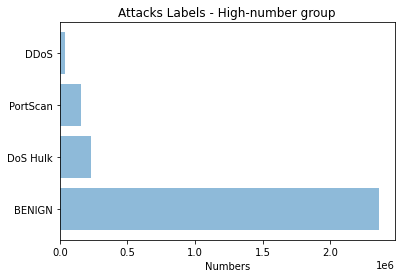

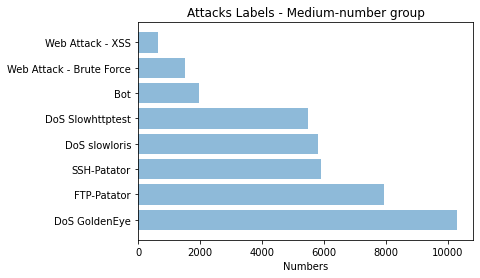

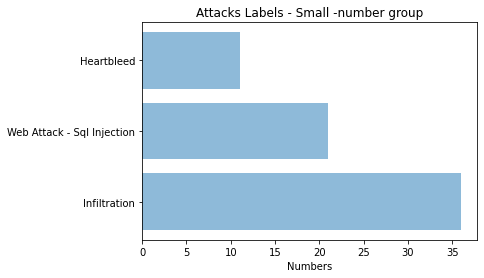

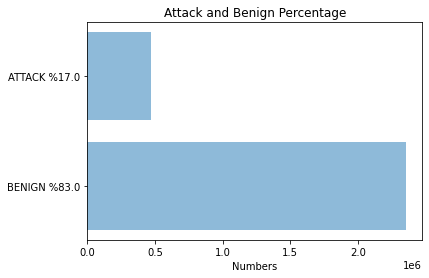

mission accomplished!
Total operation time: =  11.586140394210815 seconds


In [ ]:
##2.  all_data.csv files is required for the operation of the program.
##  all_data.csv file must be located in the same directory as the program.
##  
##  In the last graphics, the rates of all attacks and normal behaviors are given.



import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
%matplotlib inline
import time
seconds = time.time()

#  图创建函数
def graph(objects,performance,x_label,y_label):
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()


df=pd.read_csv('all_data.csv', usecols=["Label"])
print(df.iloc[:,0].value_counts())
a=(df.iloc[:,0].value_counts())



key=a.keys()
values=a.values
small_labels=[]
small_values=[]
big_labels=[]
big_values=[]
medium_labels=[]
medium_values=[]
attacak=0
benign=0


## 在本节中，攻击被分为3组，
##以便可以在图中看到所有值。
for i in range(0,len(values)):
    if values[i]>11000:
        big_labels.append(str(key[i]))
        big_values.append(values[i])
    elif values[i]<600:
        small_labels.append(str(key[i]))
        small_values.append(values[i]) 
    else:
        medium_labels.append(str(key[i]))
        medium_values.append(values[i])

    if str(key[i])=="BENIGN":
        benign+=values[i]
    else:
        attacak+=values[i]
        
key =[benign,attacak]


#函数被调用来创建一个特性
labels=["BENIGN %"+str(round(benign/(benign+attacak),2)*100),
        "ATTACK %"+str(round(attacak/(benign+attacak),2)*100)]
graph(big_labels,big_values,"Numbers","Attacks Labels - High-number group")
graph(medium_labels,medium_values,"Numbers","Attacks Labels - Medium-number group")
graph(small_labels,small_values,"Numbers","Attacks Labels - Small -number group")
graph(labels,key,"Numbers","Attack and Benign Percentage")



print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [ ]:
##3.程序的操作需要all_data.csv文件。csv文件必须位于与程序相同的目录中。这个程序的目的是生成只包含一种攻击和良性流的CSV文件。这些文件包含所有攻击流和一些良性数据流。发生率:(发作= 30%，良性=70%)，正常数据流是随机选择的

import random
import os
import pandas as pd
import time
seconds = time.time()
%matplotlib inline

def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        


print("This process may take 3 to 8 minutes, depending on the performance of your computer.\n\n\n")




# Headers of column
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]
main_labels=( ",".join( i for i in main_labels ) )

attacks=["BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris", "FTP-Patator", "Heartbleed", "Infiltration", "PortScan", "SSH-Patator", "Web Attack – Brute Force", "Web Attack – Sql Injection", "Web Attack – XSS"]
folder("./attacks/")

benign=2359289

dict_attack={
"Bot":1966,
"DDoS":41835,
"DoS GoldenEye":10293,
"DoS Hulk":231073,
"DoS Slowhttptest":5499,
"DoS slowloris":5796,
"FTP-Patator":7938,
"Heartbleed":11,
"Infiltration":36,
"PortScan":158930,
"SSH-Patator":5897,
"Web Attack - Brute Force":1507,
"Web Attack - XSS":652,
"Web Attack - Sql Injection":21}



for i in dict_attack: # 针对每种攻击类型打开一个文件，并以随机良性流记录。
    a,b=0,0
    ths = open("./attacks/"+i + ".csv", "w")
    ths.write(str(main_labels)+"\n")
    benign_num=int(benign/(dict_attack[i]*(7/3)))
    with open("all_data.csv", "r") as file:
        while True:
            try:
                line=file.readline()
                line=line[:-1]##去除这行文本最后一个字符（换行符），剩下的部分
                k=line.split(",")##通过“，”分割
                
                if k[83]=="BENIGN":
                    rnd=random.randint(1,benign_num)
                    if rnd==1:
                      ths.write(str(line)+"\n")
                      b+=1

                if k[83]==i:
                  ths.write(str(line)+"\n")
                  a+=1
                else:
                
                    continue                       
            except:
                break
    ths.close()
    print(i ,"file is completed\n attack:%d\n benign:%d\n\n\n " %(a,b))

##All web attack files are merged into a single file.
webs=["Web Attack - Brute Force","Web Attack - XSS","Web Attack - Sql Injection"]
flag=True
for i in webs:
    df=pd.read_csv("./attacks/"+str(i)+".csv")
    if flag:
        df.to_csv('./attacks/Web Attack.csv' ,index = False)
        flag=False
    else:
        df.to_csv('./attacks/Web Attack.csv' ,index = False,header=False,mode="a")
    os.remove("./attacks/"+str(i)+".csv")


print("mission accomplished!")
print("operation time: = ",time.time() - seconds ,"seconds")    


This process may take 3 to 8 minutes, depending on the performance of your computer.



Bot file is completed
 attack:1966
 benign:4658


 
DDoS file is completed
 attack:41835
 benign:98345


 
DoS GoldenEye file is completed
 attack:10293
 benign:24313


 
DoS Hulk file is completed
 attack:231073
 benign:589518


 
DoS Slowhttptest file is completed
 attack:5499
 benign:12862


 
DoS slowloris file is completed
 attack:5796
 benign:13491


 
FTP-Patator file is completed
 attack:7938
 benign:18710


 
Heartbleed file is completed
 attack:11
 benign:29


 
Infiltration file is completed
 attack:36
 benign:84


 
PortScan file is completed
 attack:158930
 benign:393550


 
SSH-Patator file is completed
 attack:5897
 benign:13782


 
Web Attack - Brute Force file is completed
 attack:1507
 benign:3475


 
Web Attack - XSS file is completed
 attack:652
 benign:1479


 
Web Attack - Sql Injection file is completed
 attack:21
 benign:29


 
mission accomplished!
operation time: =  232.043

Bot importance list:
Bot 
                              importance
Features                               
Bwd Packet Length Mean         0.322641
Flow IAT Max                   0.022428
Flow IAT Mean                  0.011343
Flow Duration                  0.007254
Flow IAT Min                   0.006960
Flow IAT Std                   0.004468
Flow Packets/s                 0.004033
Flow Bytes/s                   0.003832
Total Backward Packets         0.001388
Fwd Packet Length Mean         0.000921
Bwd Packet Length Max          0.000697
Fwd IAT Total                  0.000452
Total Length of Bwd Packets    0.000358
Total Length of Fwd Packets    0.000103
Fwd Packet Length Std          0.000103
Fwd Packet Length Max          0.000078
Bwd Packet Length Std          0.000066
Total Fwd Packets              0.000055
Fwd Packet Length Min          0.000042
Bwd Packet Length Min          0.000006 



Bot=["Bwd Packet Length Mean","Flow IAT Max","Flow IAT Mean","Flow Duration","Flow IAT Mi

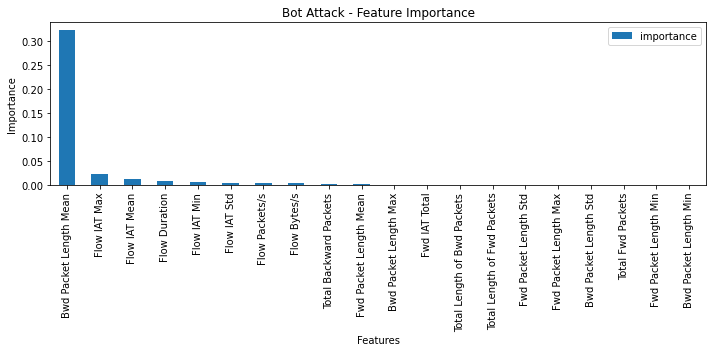

-----------------------------------------------------------------------------------------------




DDoS importance list:
DDoS 
                              importance
Features                               
Bwd Packet Length Std          0.471972
Total Backward Packets         0.094308
Fwd IAT Total                  0.010632
Flow Duration                  0.007318
Total Length of Fwd Packets    0.006634
Flow IAT Min                   0.006317
Flow IAT Std                   0.005587
Flow IAT Mean                  0.005312
Flow IAT Max                   0.004676
Flow Bytes/s                   0.003638
Fwd Packet Length Max          0.001771
Fwd Packet Length Std          0.001457
Flow Packets/s                 0.001067
Bwd Packet Length Max          0.000605
Bwd Packet Length Min          0.000460
Fwd Packet Length Mean         0.000323
Bwd Packet Length Mean         0.000227
Total Length of Bwd Packets    0.000101
Total Fwd Packets              0.000037
Fwd Packet Length Min          

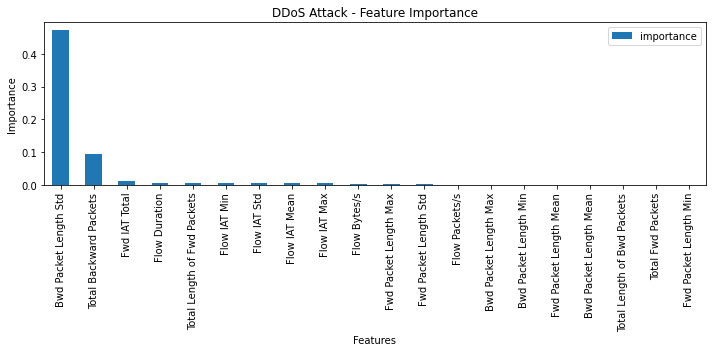

-----------------------------------------------------------------------------------------------




DoS GoldenEye importance list:
DoS GoldenEye 
                              importance
Features                               
Flow IAT Max                   0.377542
Bwd Packet Length Std          0.150954
Flow IAT Min                   0.090080
Total Backward Packets         0.024439
Flow IAT Mean                  0.011643
Fwd Packet Length Min          0.002773
Flow IAT Std                   0.002090
Bwd Packet Length Mean         0.001076
Flow Duration                  0.000793
Fwd Packet Length Max          0.000768
Flow Bytes/s                   0.000767
Fwd IAT Total                  0.000674
Flow Packets/s                 0.000660
Fwd Packet Length Mean         0.000430
Bwd Packet Length Max          0.000342
Total Length of Fwd Packets    0.000302
Total Length of Bwd Packets    0.000138
Fwd Packet Length Std          0.000084
Total Fwd Packets              0.000053
Bwd Packet Le

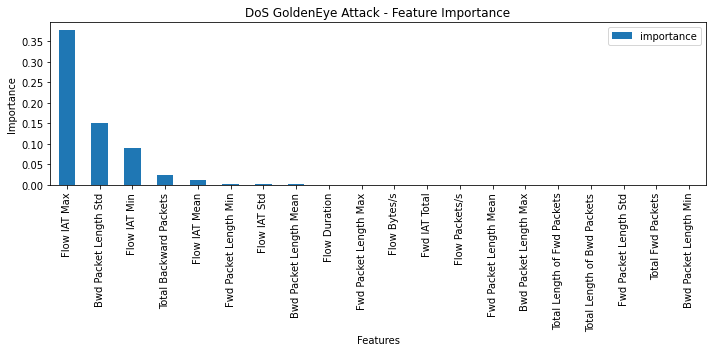

-----------------------------------------------------------------------------------------------




DoS Hulk importance list:
DoS Hulk 
                                importance
Features                                 
Bwd Packet Length Std        5.144902e-01
Fwd Packet Length Std        7.406501e-02
Fwd Packet Length Max        4.193453e-03
Flow IAT Min                 1.914804e-03
Flow Duration                1.613869e-03
Flow IAT Max                 3.723229e-04
Total Backward Packets       3.492996e-04
Flow IAT Std                 2.732980e-04
Total Length of Bwd Packets  1.885136e-04
Fwd IAT Total                1.720972e-04
Flow IAT Mean                1.143533e-04
Flow Packets/s               7.834176e-05
Flow Bytes/s                 2.740616e-05
Bwd Packet Length Mean       2.562713e-05
Bwd Packet Length Max        1.711752e-05
Fwd Packet Length Mean       9.257188e-06
Bwd Packet Length Min        8.916424e-06
Total Fwd Packets            8.636332e-06
Total Length of Fwd Pac

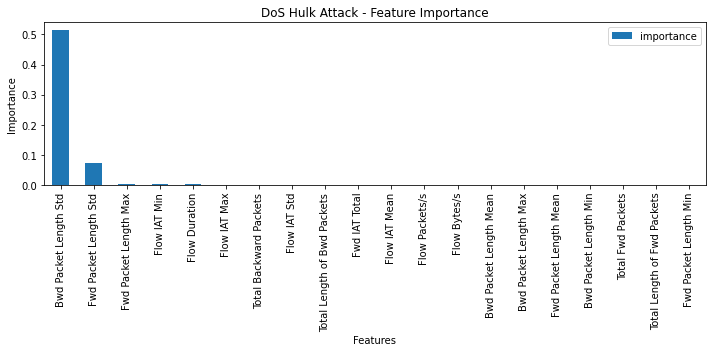

-----------------------------------------------------------------------------------------------




DoS Slowhttptest importance list:
DoS Slowhttptest 
                              importance
Features                               
Flow IAT Mean                  0.640235
Fwd Packet Length Min          0.076862
Fwd Packet Length Std          0.022254
Fwd Packet Length Mean         0.018692
Bwd Packet Length Mean         0.015087
Total Length of Bwd Packets    0.012705
Bwd Packet Length Std          0.012118
Bwd Packet Length Max          0.008960
Flow IAT Min                   0.001935
Bwd Packet Length Min          0.000901
Flow Duration                  0.000818
Fwd Packet Length Max          0.000810
Total Backward Packets         0.000752
Total Length of Fwd Packets    0.000577
Fwd IAT Total                  0.000320
Flow IAT Max                   0.000282
Total Fwd Packets              0.000241
Flow Bytes/s                   0.000239
Flow IAT Std                   0.000134
Flow Pa

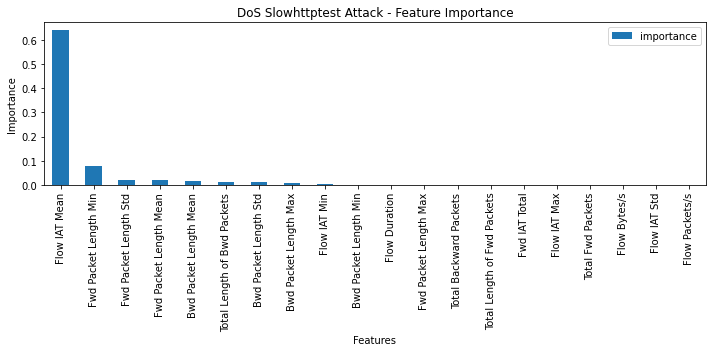

-----------------------------------------------------------------------------------------------




DoS slowloris importance list:
DoS slowloris 
                              importance
Features                               
Flow IAT Mean                  0.478570
Total Length of Bwd Packets    0.076139
Bwd Packet Length Mean         0.042399
Total Fwd Packets              0.017696
Fwd IAT Total                  0.003373
Flow IAT Max                   0.001075
Flow Bytes/s                   0.001070
Flow Duration                  0.001021
Bwd Packet Length Std          0.000745
Fwd Packet Length Std          0.000701
Flow Packets/s                 0.000668
Fwd Packet Length Max          0.000575
Bwd Packet Length Max          0.000503
Flow IAT Min                   0.000474
Fwd Packet Length Mean         0.000469
Total Length of Fwd Packets    0.000428
Total Backward Packets         0.000407
Flow IAT Std                   0.000305
Fwd Packet Length Min          0.000034
Bwd Packet Le

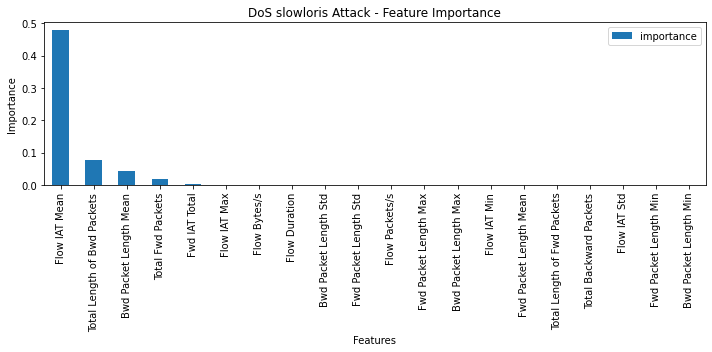

-----------------------------------------------------------------------------------------------




FTP-Patator importance list:
FTP-Patator 
                                importance
Features                                 
Fwd Packet Length Max        7.634473e-02
Fwd Packet Length Std        2.326228e-02
Bwd Packet Length Mean       1.140910e-03
Total Length of Bwd Packets  5.381622e-04
Bwd Packet Length Std        2.680163e-04
Flow IAT Min                 2.649839e-04
Flow Duration                1.525333e-04
Flow IAT Max                 1.429641e-04
Bwd Packet Length Max        1.424699e-04
Total Fwd Packets            1.245337e-04
Total Length of Fwd Packets  1.090219e-04
Flow Packets/s               8.290458e-05
Flow IAT Mean                8.156651e-05
Fwd Packet Length Mean       7.661288e-05
Fwd IAT Total                7.405909e-05
Total Backward Packets       5.628021e-05
Flow IAT Std                 3.869043e-05
Fwd Packet Length Min        3.838845e-05
Flow Bytes/s     

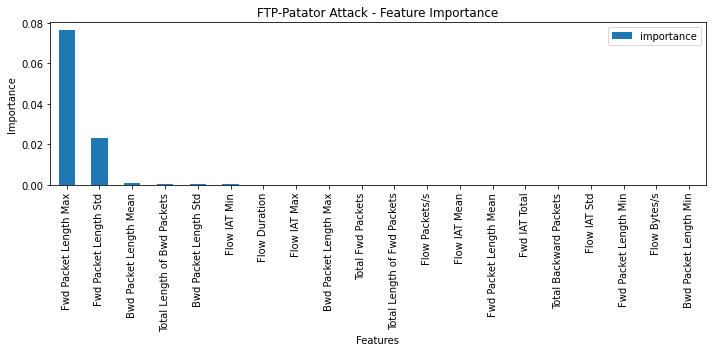

-----------------------------------------------------------------------------------------------




Heartbleed importance list:
Heartbleed 
                              importance
Features                               
Flow IAT Min                      0.048
Bwd Packet Length Mean            0.048
Bwd Packet Length Max             0.044
Total Backward Packets            0.044
Total Length of Bwd Packets       0.040
Fwd IAT Total                     0.036
Total Fwd Packets                 0.036
Flow Duration                     0.016
Total Length of Fwd Packets       0.016
Bwd Packet Length Std             0.012
Fwd Packet Length Max             0.008
Fwd Packet Length Std             0.004
Fwd Packet Length Mean            0.000
Fwd Packet Length Min             0.000
Flow Bytes/s                      0.000
Flow Packets/s                    0.000
Flow IAT Mean                     0.000
Flow IAT Std                      0.000
Flow IAT Max                      0.000
Bwd Packet Length M

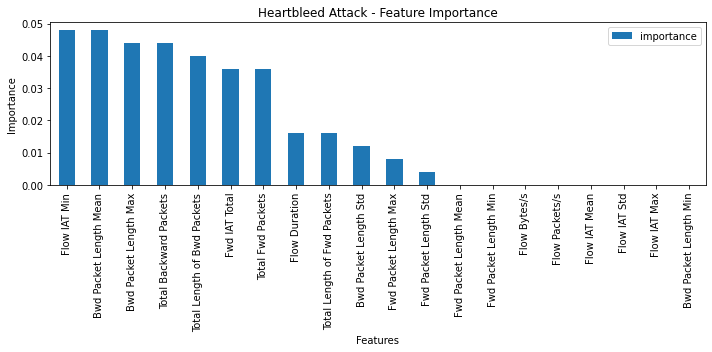

-----------------------------------------------------------------------------------------------




Infiltration importance list:
Infiltration 
                              importance
Features                               
Flow Duration                  0.207947
Total Length of Fwd Packets    0.109831
Fwd Packet Length Max          0.053093
Fwd IAT Total                  0.039578
Fwd Packet Length Mean         0.036450
Flow IAT Max                   0.019251
Bwd Packet Length Max          0.015395
Total Fwd Packets              0.014804
Bwd Packet Length Mean         0.013577
Bwd Packet Length Std          0.010231
Flow IAT Mean                  0.010019
Fwd Packet Length Std          0.009946
Flow IAT Min                   0.007487
Flow IAT Std                   0.005943
Flow Packets/s                 0.004562
Flow Bytes/s                   0.004406
Total Backward Packets         0.003315
Total Length of Bwd Packets    0.001795
Bwd Packet Length Min          0.000798
Fwd Packet Leng

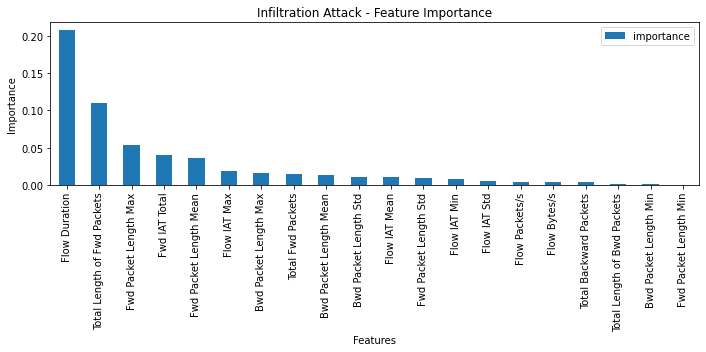

-----------------------------------------------------------------------------------------------




PortScan importance list:
PortScan 
                              importance
Features                               
Flow Bytes/s                   0.312086
Total Length of Fwd Packets    0.305500
Fwd IAT Total                  0.000249
Flow Duration                  0.000144
Fwd Packet Length Max          0.000117
Fwd Packet Length Mean         0.000073
Flow IAT Mean                  0.000050
Flow IAT Max                   0.000048
Total Fwd Packets              0.000047
Total Length of Bwd Packets    0.000031
Flow Packets/s                 0.000028
Flow IAT Min                   0.000025
Bwd Packet Length Std          0.000020
Flow IAT Std                   0.000019
Fwd Packet Length Std          0.000015
Total Backward Packets         0.000012
Bwd Packet Length Min          0.000011
Bwd Packet Length Mean         0.000005
Bwd Packet Length Max          0.000004
Fwd Packet Length Min  

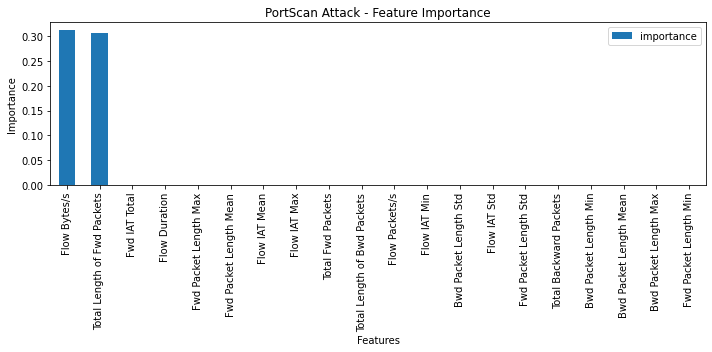

-----------------------------------------------------------------------------------------------




SSH-Patator importance list:
SSH-Patator 
                              importance
Features                               
Fwd Packet Length Max          0.001335
Flow IAT Max                   0.000511
Flow Duration                  0.000486
Total Length of Fwd Packets    0.000485
Flow Packets/s                 0.000467
Flow IAT Min                   0.000446
Flow IAT Mean                  0.000374
Fwd IAT Total                  0.000258
Fwd Packet Length Mean         0.000130
Total Backward Packets         0.000093
Fwd Packet Length Std          0.000087
Flow IAT Std                   0.000079
Flow Bytes/s                   0.000067
Total Fwd Packets              0.000065
Bwd Packet Length Min          0.000046
Fwd Packet Length Min          0.000041
Total Length of Bwd Packets    0.000039
Bwd Packet Length Mean         0.000024
Bwd Packet Length Std          0.000017
Bwd Packet Length

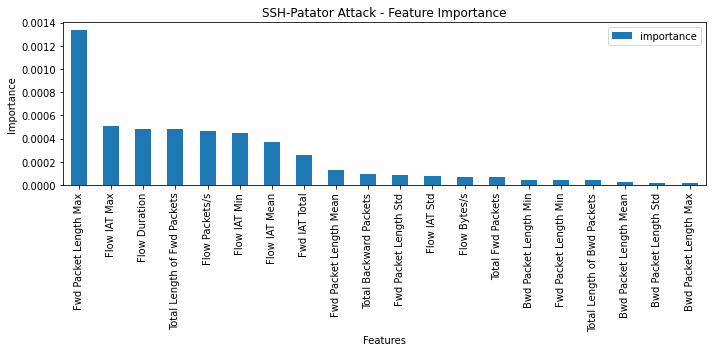

-----------------------------------------------------------------------------------------------




Web Attack importance list:
Web Attack 
                              importance
Features                               
Bwd Packet Length Std          0.010419
Total Length of Fwd Packets    0.007516
Flow Bytes/s                   0.003460
Flow IAT Min                   0.002016
Fwd Packet Length Mean         0.001371
Fwd Packet Length Std          0.001352
Bwd Packet Length Max          0.001343
Total Fwd Packets              0.001036
Flow IAT Max                   0.000718
Total Length of Bwd Packets    0.000536
Fwd Packet Length Max          0.000501
Flow Duration                  0.000416
Flow Packets/s                 0.000407
Flow IAT Mean                  0.000381
Flow IAT Std                   0.000185
Bwd Packet Length Mean         0.000144
Fwd IAT Total                  0.000105
Total Backward Packets         0.000089
Fwd Packet Length Min          0.000017
Bwd Packet Length M

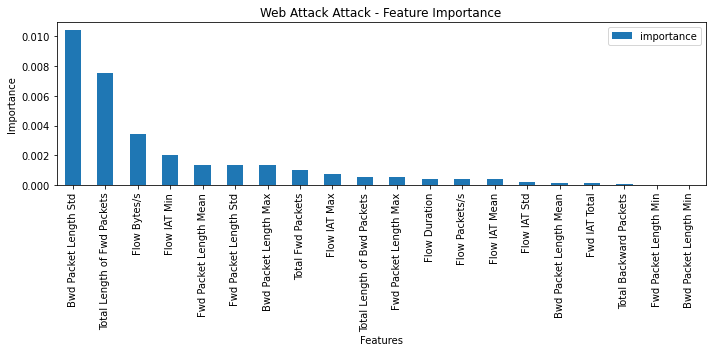

-----------------------------------------------------------------------------------------------




mission accomplished!
Total operation time: =  6769.145534992218 seconds


In [90]:
##4-1 程序的运作需要“攻击”文件夹(带有攻击csv文件)。“攻击”文件夹必须位于与程序相同的目录中。
##这段代码的目的是确定在机器学习阶段使用哪些特性。
##为此，计算攻击的重要性权重。
##使用sklearn-RandomForestRegressor进行计算。

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time
seconds = time.time()

def folder(f_name): #this function creates a folder named "feaure_pics" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

# CSV files names:
csv_files=os.listdir("attacks")# It creates a list of file names in the "attacks" folder.

# Headers of column
main_labels=["Flow Duration","Total Fwd Packets","Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label"]


ths = open("importance_list_for_attack_files.csv", "w")
folder("./feaure_pics/")

for j in csv_files:
    df=pd.read_csv(".\\attacks\\"+j,usecols=main_labels)
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#它将正常标签改为“1”，攻击标签改为“0”，用于机器学习算法中
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    #X = df.values
    X = np.nan_to_num(df.values.astype(np.float32))
    #np.where(np.isnan(X))
    #np.nan_to_num(X)


   

    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+" Attack - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")
ths.close()

In [ ]:
##4-2 “all_data。程序的操作需要csv文件。
# #”all_data。csv文件必须位于与程序相同的目录中。
##这段代码的目的是确定在机器学习阶段使用哪些特性。
##为此，计算攻击的重要性权重。
##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time
seconds = time.time()

def folder(f_name): #this function creates a folder named "feaure_pics" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

# CSV files names:
csv_files=["all_data.csv"]# It creates a list of file names in the "attacks" folder.

# Headers of column
main_labels=["Flow Duration","Total Fwd Packets",   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

ths = open("importance_list_all_data.csv", "w")
folder("./feaure_pics/")
for j in csv_files:
    df=pd.read_csv(j,usecols=main_labels)
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    X = np.nan_to_num(df.values.astype(np.float32))
    #X = df.values
   

    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+" Attack - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    #plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"secomds")
ths.close()

In [22]:
print(X)

[[4.0000e+00 2.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.0000e+00 2.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.0000e+00 2.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [1.1500e+02 1.0000e+00 1.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.9131e+05 3.0000e+00 2.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [8.1000e+01 1.0000e+00 2.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


In [20]:
np.isnan(X).any()

False

In [21]:
np.isfinite(X.all())

True

In [ ]:
##5.1 “all_data。程序的操作需要csv文件。
# #”all_data。csv文件必须位于与程序相同的目录中。
##这个程序的目的是将机器学习算法应用到数据集，并观察算法的性能。使用的算法有:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest neighbour
##作为程序显示输出的数据包括:文件名、机器学习算法名称、准确率、精度、召回率、f1得分、时间
##该程序将创建一个CSV文件，该文件将打印结果和包含结果的文件夹

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")


result="./results/results_1.csv" #a CSV file is named in which the results are saved.
csv_files=os.listdir("attacks")# 获取攻击文件夹中的文件名称并分配给一个列表(csv_files)。
path=".\\attacks\\"
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_1/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3)}



# the features to be used for each attack type is defined in a dictionary(features).
# the first 4 of the features created by the file "04_1_feature_selection_for_attack_files.py" are used here.
features={"Bot":["Bwd Packet Length Mean","Flow IAT Max","Flow Duration","Flow IAT Min","Label"],
"DDoS":["Bwd Packet Length Std","Total Backward Packets","Fwd IAT Total","Flow Duration","Label"],
"DoS GoldenEye":["Flow IAT Max","Bwd Packet Length Std","Flow IAT Min","Total Backward Packets","Label"],
"DoS Hulk":["Bwd Packet Length Std","Fwd Packet Length Std","Fwd Packet Length Max","Flow IAT Min","Label"],
"DoS Slowhttptest":["Flow IAT Mean","Fwd Packet Length Min","Bwd Packet Length Mean","Total Length of Bwd Packets","Label"],
"DoS slowloris":["Flow IAT Mean","Total Length of Bwd Packets","Bwd Packet Length Mean","Total Fwd Packets","Label"],
"FTP-Patator":["Fwd Packet Length Max","Fwd Packet Length Std","Fwd Packet Length Mean","Bwd Packet Length Std","Label"],
"Heartbleed":["Total Backward Packets","Fwd Packet Length Max","Flow IAT Min","Bwd Packet Length Max","Label"],
"Infiltration":["Fwd Packet Length Max","Fwd Packet Length Mean","Flow Duration","Total Length of Fwd Packets","Label"],
"PortScan":["Flow Bytes/s","Total Length of Fwd Packets","Fwd IAT Total","Flow Duration","Label"],
"SSH-Patator":["Fwd Packet Length Max","Flow Duration","Flow IAT Max","Total Length of Fwd Packets","Label"],
"Web Attack":["Bwd Packet Length Std","Total Length of Fwd Packets","Flow Bytes/s","Flow IAT Max","Label"]}

seconds=time.time()#time stamp for all processing time



with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header
    a=[]
    
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
                  
            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')

            
            
            
            
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )


            
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
        a.append(f1)


     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.

     
    ml=["Naive Bayes","QDA","Random Forest","ID3","AdaBoost","MLP","Nearest Neighbors"]
    temp=0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharey=True)
    for c in range(2):
        for b in range(4):
            axes[c, b].boxplot(a[temp] )
            axes[c, b].set_title(str(j[0:-4])+" - "+str(ml[temp]),fontsize=7)
            axes[c, b].set_ylabel(("F measure"))
            temp+=1
            if temp==7:
                break
        if temp==7:
            break
    plt.savefig(folder_name+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    plt.show()
    print("\n------------------------------------------------------------------------------------------------------\n\n")
    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

mission accomplished!
Total operation time: =  0.008490324020385742 seconds


In [ ]:
##5.2  “all_data。程序的操作需要csv文件。
# #”all_data。csv文件必须位于与程序相同的目录中。
##这个程序的目的是将机器学习算法应用到数据集，并观察算法的性能。使用的算法有:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest neighbour
##作为程序显示输出的数据包括:文件名、机器学习算法名称、准确率、精度、召回率、f1得分、时间
##该程序将创建一个CSV文件，该文件将打印结果和包含结果的文件夹

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score



            
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")


result="./results/results_2.csv" #a CSV file is named in which the results are saved.
csv_files=["all_data.csv"]# CSV files names: #The names of the dataset files (csv_files).
path=""
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_2/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3)}



# the features to be used for each attack type is defined in a dictionary(features).
# the first 4 of the features created by the file "04_1_feature_selection_for_attack_files.py" are used here.
### The set of features to be used consists of combining the 4 features with the highest importance-weight achieved for each attack in approach 1 under a single roof.
### Thus, 4 features are obtained from each of the 12 attack types, resulting in a pool of features consisting of 48 attributes.
### After the repetitions are removed, the number of features is 18. The list of these features can be seen in below : ()

features={"all_data":["Bwd Packet Length Max","Bwd Packet Length Mean","Bwd Packet Length Std","Flow Bytes/s",
"Flow Duration","Flow IAT Max","Flow IAT Mean","Flow IAT Min","Flow IAT Std","Fwd IAT Total","Fwd Packet Length Max",
"Fwd Packet Length Mean","Fwd Packet Length Min","Fwd Packet Length Std","Total Backward Packets","Total Fwd Packets",
"Total Length of Bwd Packets","Total Length of Fwd Packets","Label"]}

seconds=time.time()#time stamp for all processing time






with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header   
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
            

            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')
            
            
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )



            
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
   
     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.
        plt.boxplot(f1)
        plt.title("All Dataset - " +str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name+j[0:-4]+str(ii)+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
        plt.show()# you can remove the # sign if you want to see the graphics simultaneously

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [ ]:
##5.3  “all_data。程序的操作需要csv文件。
# #”all_data。csv文件必须位于与程序相同的目录中。
##这个程序的目的是将机器学习算法应用到数据集，并观察算法的性能。使用的算法有:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest neighbour
##作为程序显示输出的数据包括:文件名、机器学习算法名称、准确率、精度、召回率、f1得分、时间
##该程序将创建一个CSV文件，该文件将打印结果和包含结果的文件夹
##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score




            
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")


result="./results/results_3.csv" #a CSV file is named in which the results are saved.
csv_files=["all_data.csv"]# CSV files names: #The names of the dataset files (csv_files).
path=""
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_3/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3)}



#list of all columns to be imported
# the 7 features with the highest importance weight selected by the file "04_2_feature_selection_for_attack_files.py" are used here. (+ Label Feature)

features={"all_data":["Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
     "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total","Label"]}

seconds=time.time()#time stamp for all processing time




with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header   
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).

            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
            
            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')

            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )


            
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
   
     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.
        plt.boxplot(f1)
        plt.title("All Dataset - " +str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name+j[0:-4]+str(ii)+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
        plt.show()# you can remove the # sign if you want to see the graphics simultaneously

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [ ]:
##5.4  “all_data。程序的操作需要csv文件。
# #”all_data。csv文件必须位于与程序相同的目录中。
##这个程序的目的是将机器学习算法应用到数据集，并观察算法的性能。使用的算法有:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest neighbour
##作为程序显示输出的数据包括:文件名、机器学习算法名称、准确率、精度、召回率、f1得分、时间
##该程序将创建一个CSV文件，该文件将打印结果和包含结果的文件夹

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")



def folder(f_name): #this function creates a folder named "feaure_graph" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

result="./results/results_Final.csv" #a CSV file is named in which the results are saved.
csv_files=["all_data.csv"]# CSV files names: #The names of the dataset files (csv_files).
path=""
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_Final/"
folder(folder_name)



# the 20 features selected by the file "04_2_feature_selection_for_attack_files.py" are used here. (+ Label Feature)
usecols=["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Std","Flow IAT Std",
"Flow IAT Min","Fwd IAT Total","Flow Duration","Bwd Packet Length Max","Flow IAT Max","Flow IAT Mean","Total Length of Bwd Packets",
"Fwd Packet Length Min","Bwd Packet Length Mean","Flow Packets/s","Fwd Packet Length Mean","Total Backward Packets","Total Fwd Packets",
"Fwd Packet Length Max","Bwd Packet Length Min",'Label']




#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"Nearest Neighbors":KNeighborsClassifier(3)}




# 随机森林、ID3、AdaBoost、最近的邻居使用的特性在一个列表中定义(others)。
#文件"04_2_feature_selection_for_attack_files创建的前7个特性。。
others=["Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
     "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total"]

#在这一部分中，机器学习方法的不同属性集定义如下:对于“朴素贝叶斯”、“QDA”和“MLP”，每种方法都有一个不同的特性列表。其他算法(随机森林，ID3, AdaBoost，和最近的邻居)使用
#文件"04_2_feature_selection_for_attack_files创建的前7个特性。
algorithms_features={"Naive Bayes":['Bwd Packet Length Std', 'Total Length of Fwd Packets', 'Flow IAT Min', 'Fwd Packet Length Min', 'Flow Packets/s', 'Fwd Packet Length Mean'] ,
"QDA":['Bwd Packet Length Std', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Flow IAT Min'], 
"MLP":['Bwd Packet Length Std', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Fwd Packet Length Std',
'Flow IAT Min', 'Bwd Packet Length Max','Fwd Packet Length Min', 'Bwd Packet Length Mean',
'Total Backward Packets', 'Total Fwd Packets', 'Fwd Packet Length Max', 'Bwd Packet Length Min'],


#these algorithms use the features in the "others" list
"Random Forest":others,
"ID3" :others,
"AdaBoost":others,
"Nearest Neighbors":others}

seconds=time.time()#time stamp for all processing time




with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])

for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header
    feature_list=usecols
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        X = df[algorithms_features[ii]]
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm. 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
            

            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')

            

            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )


            
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the avarage result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file



        # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.
        plt.boxplot(f1)
        plt.title("All Dataset - " +str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name+j[0:-4]+str(ii)+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
        plt.show()# you can remove the # sign if you want to see the graphics simultaneously
        
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [ ]:
##5.4.2 “all_data。程序的操作需要csv文件。
# #”all_data。csv文件必须位于与程序相同的目录中。
##这个程序的目的是为朴素贝叶斯和QDA和MLP算法找到最优的属性列表。它遵循一种试错的方法。
##从文件“04_2_feature_selection_for_attack_files”中获得的特性列表。在机器学习算法中，以最高的重要性分开始。
##如果每个特性的F-measure等于或大于获得的最高值，则添加此属性
##




#%matplotlib inline
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score




            
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time
seconds = time.time()


#list of all columns to be imported
# the 20 features selected by the file "04_2_feature_selection_for_attack_files.py" are used here. (+ Label Feature)
features=["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Std",
"Flow IAT Std","Flow IAT Min","Fwd IAT Total","Flow Duration","Bwd Packet Length Max","Flow IAT Max",
"Flow IAT Mean","Total Length of Bwd Packets","Fwd Packet Length Min","Bwd Packet Length Mean",
"Flow Packets/s","Fwd Packet Length Mean","Total Backward Packets","Total Fwd Packets","Fwd Packet Length Max",
"Bwd Packet Length Min",'Label']
    
df=pd.read_csv('all_data.csv',usecols=features)#CSV rading



print ('%-17s %-17s ' % ("Feature Number","Feature"))# print output header
for i in range(len(features)-1):
    print ('%-17s %-17s' % (i+1,features[i]))# print features  and feature numbers 


print ('\n\n\n')

attack_or_not=[]
for i in df.iloc[:,-1]:
    if i =="BENIGN":#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        attack_or_not.append(1)
    else:
        attack_or_not.append(0)
df.iloc[:,-1]=attack_or_not
y = df.iloc[:, -1].values #labes-y
my_list=[]


least=0



ml_list={#The machine learning algorithms to be used are defined in a dictionary (ml_list).
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
##"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
##"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
##"AdaBoost":AdaBoostClassifier(),
##"Nearest Neighbors":KNeighborsClassifier(3),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)}


features.pop()#the Label tag is removed, no need any more
print ('%-17s %-30s %-10s  %-10s %-15s ' % ("ML algorithm","Feature Name","F1-score","Accuracy", "Feature List"))# print output header
for j in ml_list: # run for every machine learning.  
    my_list=[]
    for i in features: ## run for every  feature  
        my_list.append(i)
        X = df.loc[:, my_list].values # data

        ## cross-validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
       
        #machine learning algorithm is applied in this section
        clf = ml_list[j]   #                                                                       
        clf.fit(X_train, y_train)
        predict =clf.predict(X_test)
        f1=clf.score(X_test, y_test)
        result=f1_score(y_test, predict, average='macro')
        accuracy=round(clf.score(X_test, y_test),2)
        temp="["
       
        for ii in my_list: 
            temp+=str(my_list.index(ii)+1)+", " #translate property list to sequence number for less space

       
        if result>=least:# If the F-criterion is equal to or greater than the highest value previously accessed, keep the new feature. 
            least=result
            print ('%-17s %-30s %-10s  %-10s %-15s %-15s ' % (j,i,result,accuracy ,temp, "------> New feature found!!!"))

        else:#If not, remove it from the list
            my_list.remove(my_list[len(my_list)-1])
            print ('%-17s %-30s %-10s  %-10s %-15s ' % (j,i,result,accuracy ,temp))
    print("F1=" ,least,j," The most efficient feature list =",my_list,"\n\n") #print maximum F1 and the most efficient feature list




print("mission accomplished!")
print("operation time: = ",time.time()- seconds ,"secomds")